In [194]:
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
from torch.utils.data import TensorDataset
from pathlib import Path
import random
import numpy as np

from torchvision import datasets, transforms

from two_spirals_utils import spiral_dataset, SpiralClassifier
from utils.utils import get_grid_predictions, create_contour_plot, resnet_CIFAR10
from utils.attacks import fgsm, pgd

# Entire Attack and Defence Pipeline

In this notebook we demostrate our proposed defence method. This document is structured as follows:
1. Create advesarial CIFAR10 samples
2. Test accuracy on normal dataset
2. Test accuracy on the adversarial dataset
3. Project the samples using the learned manifold
4. Test accuracy on the projected samples

## Load ResNet

In [195]:
# Assuming the checkpoint is stored at './resnet_checkpoint.pth'
checkpoint_path = '../models/resnet/resnet50_cifar10.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create an instance of the model
classifier = resnet_CIFAR10(resnet_checkpoint=checkpoint_path, device=device)

## Create adversarial CIFAR10 sample

### Load CIFAR10

In [196]:
# Load the CIFAR10 dataset
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# CIFAR10 class labels for reference
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified


In [197]:
img = dataset[1][0]
print(img)


tensor([[[ 2.1264,  2.0489,  2.0682,  ...,  2.0876,  2.0876,  2.0682],
         [ 2.1845,  2.1264,  2.1264,  ...,  2.1458,  2.1458,  2.1264],
         [ 2.1652,  2.1070,  2.1070,  ...,  2.1264,  2.1264,  2.1070],
         ...,
         [-0.7426, -1.5955, -2.0608,  ...,  0.8470,  1.0990,  1.2153],
         [-0.8395, -1.5374, -1.7312,  ...,  0.9439,  1.1571,  1.1959],
         [-0.7813, -1.2272, -1.3047,  ...,  0.8276,  1.0602,  1.1765]],

        [[ 2.2035,  2.1248,  2.1445,  ...,  2.1641,  2.1641,  2.1445],
         [ 2.2625,  2.2035,  2.2035,  ...,  2.2231,  2.2231,  2.2035],
         [ 2.2428,  2.1838,  2.1838,  ...,  2.2035,  2.2035,  2.1838],
         ...,
         [-0.4712, -1.4152, -1.9659,  ...,  1.2004,  1.4561,  1.5544],
         [-0.5302, -1.2972, -1.5529,  ...,  1.2988,  1.5151,  1.5544],
         [-0.4319, -0.9432, -1.1006,  ...,  1.1808,  1.4168,  1.5151]],

        [[ 2.3635,  2.2855,  2.3050,  ...,  2.3245,  2.3245,  2.3050],
         [ 2.4221,  2.3635,  2.3635,  ...,  2

In [198]:

def unnormalize(img):
    img = img.clone().detach().numpy()  # Clone and convert to numpy
    img = img.transpose((1, 2, 0))  # Rearrange dimensions to Width x Height x Channels
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = img * std + mean
    img = np.clip(img, 0, 1)  # Limit values to range [0, 1]
    return img

def normalize(img):
    # Assumes img is a PyTorch tensor with shape [Channels, Height, Width]
    # Convert to numpy and rearrange dimensions if needed (from CHW to HWC)
    img = img.clone().detach().permute(1, 2, 0).numpy()
    
    # Define the mean and standard deviation for each channel
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    
    # Normalize the image
    img = (img - mean) / std
    img = np.clip(img, 0, 1)  # Optional: Clip values to ensure they stay between 0 and 1
    
    # Convert back to PyTorch tensor and revert dimensions back to CxHxW
    img = torch.from_numpy(img).float().permute(2, 0, 1)
    
    return img


# Function for visualizing images
def imshow(img, label):
    
    img = unnormalize(img)
    
    plt.imshow(img)
    plt.title(f"Label: {classes[label]}")
    plt.show()

### Pick and display a random image

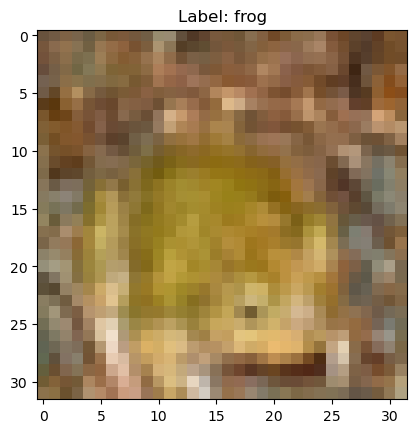

In [199]:
n_adv_samples = 1

eps = 0.02

# Pick an index at random
idx = random.randint(0, len(dataset) - 1)

# Retrieve the image and label
orig_image, orig_label = dataset[idx]

imshow(orig_image, orig_label)

In [200]:
orig_image

tensor([[[-0.4130, -0.2192,  0.0328,  ..., -0.6069, -0.0447, -0.1029],
         [-0.1223,  0.2267,  0.4011,  ..., -0.5293, -0.2580, -0.1223],
         [-0.1804, -0.0060,  0.2654,  ..., -0.4712, -0.2192, -0.2580],
         ...,
         [-0.4906, -0.3743,  0.0716,  ..., -0.1223, -0.0060,  0.5368],
         [-0.2580,  0.1104, -0.1223,  ...,  0.4011,  0.4593,  1.0796],
         [ 0.2848,  0.2654, -0.3355,  ..., -0.1416,  0.3817,  0.9633]],

        [[-0.8056, -0.6482, -0.4909,  ..., -1.2382, -0.7466, -0.8056],
         [-0.7269, -0.3336, -0.1762,  ..., -1.1202, -0.9236, -0.8056],
         [-0.8056, -0.5302, -0.2549,  ..., -1.0809, -0.9236, -0.9236],
         ...,
         [-0.5499, -0.8646, -0.4122,  ..., -0.9236, -0.6286,  0.1384],
         [-0.6089, -0.4909, -0.7269,  ..., -0.3139, -0.1369,  0.7481],
         [-0.1762, -0.2156, -0.8252,  ..., -0.6089, -0.0386,  0.7678]],

        [[-1.0118, -0.8947, -0.8752,  ..., -1.5385, -1.2849, -1.2849],
         [-1.0313, -0.6996, -0.6996,  ..., -1

### Perturb the image using adversarial attacks

## Test accuracy on normal data

In [201]:
logits = classifier(orig_image[None])
# probabilities = torch.softmax(logits, dim=0)

# Get the predicted label as the index of the highest probability
predicted_label = torch.argmax(logits).item()

print("Probabilities:", logits)
print("Predicted Label:", classes[predicted_label])

Probabilities: tensor([[-0.2751, -1.2707,  0.6334,  0.5962,  0.7385,  0.1252,  0.3150, -0.2236,
         -0.0448, -0.7351]], grad_fn=<AddmmBackward0>)
Predicted Label: deer


## Test accuracy on the adversarial dataset

In [202]:
x_adv = fgsm(classifier, x=orig_image[None], label=orig_label, eps=eps, targeted=False).detach()

x_adv.shape

torch.Size([1, 3, 32, 32])

In [203]:
classifier(x_adv)

# Get the predicted label as the index of the highest probability
adv_predicted_label = torch.argmax(logits).item()

print("Probabilities:", logits)
print("Predicted Label:", classes[adv_predicted_label])

Probabilities: tensor([[-0.2751, -1.2707,  0.6334,  0.5962,  0.7385,  0.1252,  0.3150, -0.2236,
         -0.0448, -0.7351]], grad_fn=<AddmmBackward0>)
Predicted Label: deer


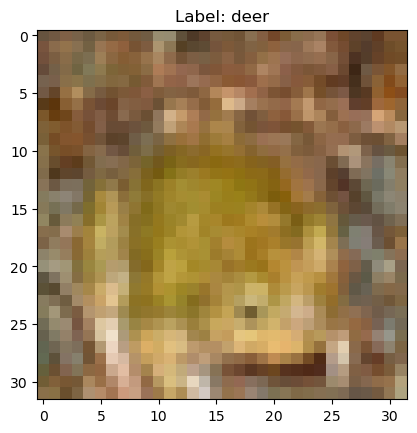

The attack was successful!
The true label is frog. The predicted label is deer.


In [204]:
imshow(x_adv[0], adv_predicted_label)
if (adv_predicted_label != orig_label):
    print(f"The attack was successful!")
    print(f"The true label is {classes[orig_label]}. The predicted label is {classes[adv_predicted_label]}.")
else:
    print(f"The attack was not successful!")

## Project the samples using the learned manifold

In [205]:
from manifold_flow.flows import ManifoldFlow
from manifold_flow import transforms
from manifold_flow.architectures.vector_transforms import create_vector_transform
from manifold_flow.architectures.image_transforms import create_image_transform


In [206]:
latentdim = 553
outerlayers = 20
innerlayers = 6
levels = 4
splinebins = 11
splinerange = 10.0
dropout = 0.0
actnorm = True
batchnorm = False
contextfeatures = None
linlayers = 2
linchannelfactor = 1
lineartransform = "lu"

steps_per_level = outerlayers // levels

mflow = ManifoldFlow(
        data_dim=(3, 32, 32),
        latent_dim=latentdim,
        inner_transform = create_vector_transform(
            dim = latentdim,
            flow_steps = 16 , # previously 6
            linear_transform_type = "permutation",
            base_transform_type = "rq-coupling",
            hidden_features = 100,
            num_transform_blocks = 6, #previously 2
            dropout_probability=0.0,
            use_batch_norm=False,
            num_bins=8,
            tail_bound=3,
            apply_unconditional_transform=False,
            context_features=None,
        ),
        outer_transform=create_image_transform(
            3,
            32,
            32,
            levels=4,
            hidden_channels=100,
            steps_per_level=steps_per_level,
            num_res_blocks=2,
            alpha=0.05,
            num_bits=8,
            preprocessing="glow",
            dropout_prob=dropout,
            multi_scale=True,
            num_bins=splinebins,
            tail_bound=splinerange,
            postprocessing="partial_nsf",
            postprocessing_layers=linlayers,
            postprocessing_channel_factor=linchannelfactor,
            use_actnorm=actnorm,
            use_batchnorm=batchnorm,
        )
    )

# Load model state dict on CPU
mflow.load_state_dict(torch.load("../models/cifar10_mflow/mflow_cifar10_nsamples5000_normalized_dim553.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [207]:
x_adv.shape

torch.Size([1, 3, 32, 32])

In [208]:
# x_adv = unnormalize(x_adv[0])*255
# # Convert back to PyTorch tensor
# x_adv = torch.from_numpy(x_adv).int()  # Convert numpy array back to tensor
# x_adv = x_adv.permute(2, 0, 1)  # Rearrange dimensions from HxWxC to CxHxW
# x_adv = x_adv.unsqueeze(0)

In [209]:
x_adv.min(), x_adv.max()

(tensor(-1.9878), tensor(2.2421))

In [210]:
# Transform adversarial attack sample into latent space
x_latent = mflow.encode(x_adv.to(device))

# Project adversarial attack sample onto manifold
x_proj   = mflow.decode(x_latent.to(device)).detach()

In [211]:
x_proj.min(), x_proj.max()

(tensor(-2.1978), tensor(3.3793))

In [212]:
logits = classifier(x_proj)

# Get the predicted label as the index of the highest probability
proj_predicted_label = torch.argmax(logits).item()

print("Probabilities:", logits)
print("Predicted Label:", classes[proj_predicted_label])

Probabilities: tensor([[-0.1476, -0.7703,  1.2137,  1.1627,  0.0359,  0.4680,  0.4941, -1.3521,
         -0.5745, -0.5023]], grad_fn=<AddmmBackward0>)
Predicted Label: bird


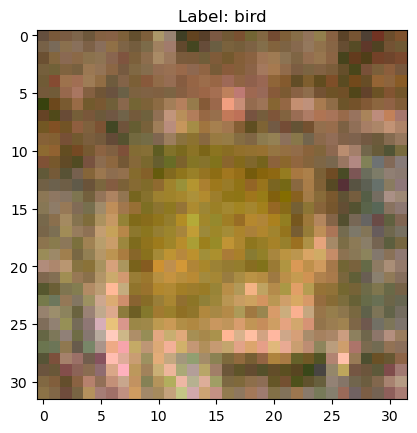

The attack was unsuccessful! Our defense made things worse.
The correct label is: frog, the predicted label is : deer, and after the defense it is: bird


In [213]:
# Display the selected image and its label
# _, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
# ax[0].imshow(x_adv[0].permute(1, 2, 0), interpolation="nearest")
# ax[0].set_title(f"Adversarial")
# ax[0].axis("off")

# ax[1].imshow(x_proj[0].permute(1, 2, 0), interpolation="nearest")

# ax[1].set_title("Projected")
# ax[1].axis("off");

imshow(x_proj[0], proj_predicted_label)

if (proj_predicted_label != adv_predicted_label and proj_predicted_label == orig_label and adv_predicted_label != orig_label):
    print(f"The attack was successful! Our defense was successful too.")
    print(f"The true label is {classes[orig_label]}. The predicted label is {classes[adv_predicted_label]}.")
    print(f"After projecting onto to the manifold the predicted label is {classes[proj_predicted_label]}.")
elif (proj_predicted_label == adv_predicted_label and adv_predicted_label != orig_label):
    print(f"The attack was successful! But our defense was unsuccessful.")
elif (adv_predicted_label == orig_label and proj_predicted_label == adv_predicted_label):
    print(f"The attack was unsuccessful! Our defense did not worsen it.")
    print(f"The correct label is {classes[orig_label]}, the predicted label is : {classes[adv_predicted_label]}, and after the defense it is:{classes[proj_predicted_label]}")
else:
    print(f"The attack was unsuccessful! Our defense made things worse.")
    print(f"The correct label is: {classes[orig_label]}, the predicted label is : {classes[adv_predicted_label]}, and after the defense it is: {classes[proj_predicted_label]}")


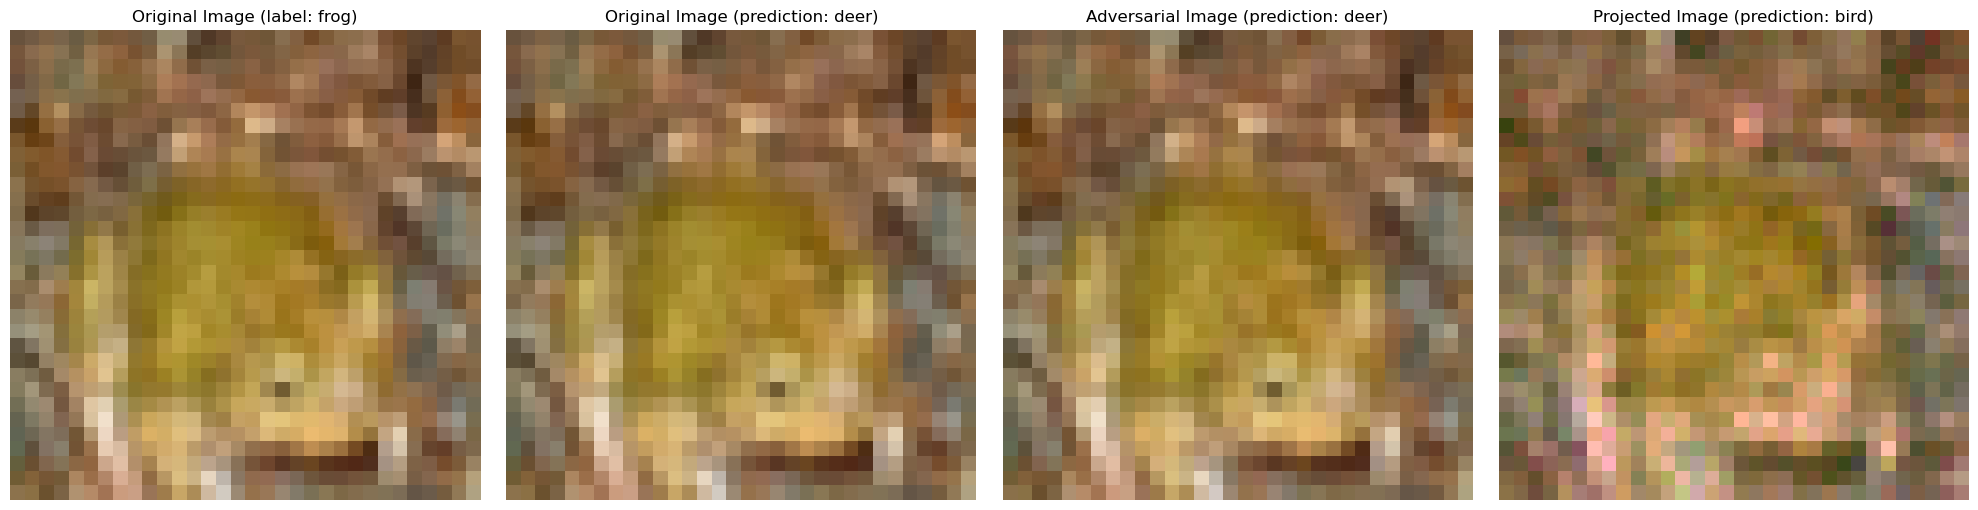

In [214]:
# Assuming images are numpy arrays named img1, img2, img3
# For demonstration, let's create dummy data for these images
img1 = unnormalize(orig_image)  # Random image 1
img2 = unnormalize(orig_image)  # Random image 3
img3 = unnormalize(x_adv[0])  # Random image 2
img4 = unnormalize(x_proj[0])  # Random image 3

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

# Plot each image on its respective axis
axs[0].imshow(img1)
axs[0].set_title(f"Original Image (label: {classes[orig_label]})")
axs[0].axis('off')  # Turn off axis

axs[1].imshow(img2)
axs[1].set_title(f"Original Image (prediction: {classes[predicted_label]})")
axs[1].axis('off')  # Turn off axis

axs[2].imshow(img3)
axs[2].set_title(f"Adversarial Image (prediction: {classes[adv_predicted_label]})")
axs[2].axis('off')  # Turn off axis

axs[3].imshow(img4)
axs[3].set_title(f"Projected Image (prediction: {classes[proj_predicted_label]})")
axs[3].axis('off')  # Turn off axis

# Display the plot
plt.tight_layout()  # Adjust layout to not overlap
plt.show()

In [215]:
dims = np.linspace(2, 3072, 40, dtype=np.int32)
dims

array([   2,   80,  159,  238,  316,  395,  474,  553,  631,  710,  789,
        867,  946, 1025, 1104, 1182, 1261, 1340, 1418, 1497, 1576, 1655,
       1733, 1812, 1891, 1969, 2048, 2127, 2206, 2284, 2363, 2442, 2520,
       2599, 2678, 2757, 2835, 2914, 2993, 3072], dtype=int32)